# Projet 5 : Segmentez des clients d'un site e-commerce

# Partie 2 : Essais des différentes approches de modélisation

Ce notebook d'essais des différentes approches de modélisation est organisé de la manière suivante :

* [**1. Import du jeu de données**](#1.-Import-du-jeu-de-données)
* [**2. Feature engineering**](#2.-Feature-engineering)
* [**3. Essais des différents algorithmes de clustering**](#3.-Essais-des-différents-algorithmes-de-clustering)
  * [**3.1 Clustering en utilisant l'algorithme du KMeans**](#3.1-Clustering-en-utilisant-l'algorithme-du-KMeans)
  * [**3.2 Clustering en utilisant l'algorithme de clustering hiérarchique**](#3.2-Clustering-en-utilisant-l'algorithme-de-clustering-hiérarchique)
  * [**3.3 Clustering en utilisant l'algorithme du DBSCAN**](#3.3-Clustering-en-utilisant-l'algorithme-du-DBSCAN)
  * [**3.4 Clustering en utilisant l'algorithme du K-Prototypes**](#3.4-Clustering-en-utilisant-l'algorithme-du-K-Prototypes)
  * [**3.5 Sélection du modèle final**](#3.5-Sélection-du-modèle-final)
* [**4. Segmentation de l'ensemble des clients en matière de commandes et de satisfaction**](#4.-Segmentation-de-l'ensemble-des-clients-en-matière-de-commandes-et-de-satisfaction)
  * [**4.1 Application de l'algorithme du KMeans**](#4.1-Application-de-l'algorithme-du-KMeans)
  * [**4.2 Définition des différents segments**](#4.2-Définition-des-différents-segments)
* [**Conclusion**](#Conclusion)

In [1]:
# Project 5: Segment customers of an e-commerce site
# Part 2: Testing different modelisation approaches
# Import libraries
import warnings
%pylab inline
import pandas as pd


# Sickit-Learn library
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.utils import resample
from sklearn import decomposition
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Kneed package
from kneed import KneeLocator

# Kmodes package
from kmodes.kprototypes import KPrototypes

# Yellowbrick library
from yellowbrick.cluster import (SilhouetteVisualizer, KElbowVisualizer,
                                 intercluster_distance)

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

Populating the interactive namespace from numpy and matplotlib


## 1. Import du jeu de données

In [2]:
# 1. Loading the customers dataset
customers_df = pd.read_csv('customers_df.csv', sep=',')

In [3]:
# Dimensions of the dataset
customers_df.shape

(96096, 21)

In [4]:
# Displaying five first rows of the dataset
customers_df.head(10)

,customer_unique_id,frequency,price,payment_value,freight_value,review_score,recency,day,month,year,...,customer_city,customer_state,monetary,r_score,f_score,m_score,rfm_score,score,shopping_habits,consumption_habits
0,8d50f5eadf50201ccdcedfb9e2ac8455,17,729.62,927.63,172.42,4.764706,58,20,8,2018,...,sao paulo,SP,927.63,5,5,5,555,4,sao paulo,sports_leisure
1,3e43e6105506432c953e165fb2acf44c,10,897.15,1536.84,138.78,2.800000,232,27,2,2018,...,praia grande,SP,1536.84,3,5,5,355,3,ibitinga,bed_bath_table
2,6469f99c1f9dfae7733b25662e7f1782,8,639.30,905.11,85.54,5.000000,111,28,6,2018,...,santos,SP,905.11,5,5,5,555,5,piracicaba,bed_bath_table
3,ca77025e7201e3b30c44b472ff346268,8,723.65,1336.40,186.09,5.000000,138,1,6,2018,...,recife,PE,1336.40,5,5,5,555,5,pedreira,furniture_decor
4,1b6c7548a2a1f9037c1fd3ddfed95f33,8,691.21,1085.99,134.22,5.000000,245,14,2,2018,...,ituiutaba,MG,1085.99,3,5,5,355,4,pedreira,furniture_decor
5,c8ed31310fc440a3f8031b177f9842c3,7,827.40,8100.96,11.48,3.000000,66,12,8,2018,...,ipua,SP,8100.96,5,5,5,555,4,teixeira soares,construction_tools_construction
6,47c1a3033b8b77b3ab6e109eb4d5fdf3,7,836.60,1086.78,107.61,4.857143,266,24,1,2018,...,jandira,SP,1086.78,3,5,5,355,4,volta redonda,auto
7,d97b3cfb22b0d6b25ac9ed4e9c2d481b,7,473.99,5313.88,79.69,1.000000,365,17,10,2017,...,sao paulo,SP,5313.88,2,5,5,255,3,ibitinga,bed_bath_table
8,12f5d6e1cbf93dafd9dcc19095df0b3d,6,58.40,110.72,52.32,5.000000,650,5,1,2017,...,curitiba,PR,110.72,1,5,3,153,3,curitiba,furniture_bedroom
9,a40096fc0a3862e9e12bc55b5f8e6ab2,6,337.75,1170.26,88.69,1.000000,371,11,10,2017,...,rio de janeiro,RJ,1170.26,2,5,5,255,3,sao bernardo do campo,bed_bath_table


## 2. Feature engineering

Nous allons commencer par la sélection des variables pertinentes. Pour constituer le subset d'essais des différentes approches de modélisation, on sélectionne tous les clients qui ont réalisé plusieurs commandes et un échantillon des clients qui ont réalisé une seule commande.

In [5]:
# 2. Feature engineering
# Selection of relevant features
num_features = ['recency',
                'frequency',
                'monetary',
                'score',
                'review_score']

cat_features = ['consumption_habits', 'shopping_habits']

# Creating a subset dataset based on orders frequency
df1 = customers_df[customers_df.frequency > 1]
df2 = customers_df[customers_df.frequency == 1]
df2 = resample(
    df2,
    n_samples=30000,
    random_state=0)
df2.reset_index(inplace=True, drop=True)
subset_df = df1.append(df2)
subset_df.reset_index(inplace=True, drop=True)
subset_df.shape

(35074, 21)

## 3. Essais des différents algorithmes de clustering

Nous allons essayer différents algorithmes de clustering. Les algorithmes utilisés sont :
- Le KMeans ;
- Le Clustering hiérarchique (Clustering agglomératif) ;
- Le DBSCAN ;
- Le K-Prototypes.

Nous utilisons la méthode du coude pour déterminer le nombre optimal de clusters et pour la configuration des paramètres des algorithmes. Pour évaluer les algorithmes de clustering, nous utilisons les métriques suivantes :
- Le coefficient de Silhouette : la mesure de la qualité d’une partition de données permet d’évaluer si un point appartient au bon cluster et si le cluster répond aux exigences d’homogénéité et de séparation.
- L’index de Davies-Bouldin : la mesure de similarité moyenne est le rapport entre les distances intra-clusters (l’homogénéité) et les distances inter-clusters (la séparation).
- Le score de distorsion : la somme moyenne des carrés des distances aux centres.

In [6]:
# 3. Testing of different clustering algorithms
def preprocessing(data, num_features, cat_features, n_comp):
    """This function is used for normalization, standardization,
    and encoding data. It also performs a PCA.
    """
    # Normalization
    num_df = data[num_features]
    transformer = QuantileTransformer(output_distribution='normal',
                                      random_state=0)
    norm_df = pd.DataFrame(transformer.fit_transform(num_df),
                           columns=num_features)

    # Standardization
    scaler = StandardScaler()
    norm_df = scaler.fit_transform(norm_df)
    norm_df = pd.DataFrame(norm_df,
                           columns=num_features)

    # Add categorical features 
    if cat_features is not None:
        for feature in cat_features:
            norm_df[feature] = data[feature]

        # If algorithm works with categorical features
        if n_comp is not None:
            # Encoding categorical features
            norm_df = pd.get_dummies(norm_df,
                                     columns=cat_features)

            # Performing PCA
            pca = decomposition.PCA(n_components=n_comp)
            reduced_data = pca.fit_transform(norm_df)
            print("Dimensions of dataset after "
                  "preprocessing: {}".format(norm_df.shape))

            # Percentage of variance explained by each component
            print("Percentage of variance explained "
                  "by each component: ")
            print(pca.explained_variance_ratio_)
            print(pca.explained_variance_ratio_.cumsum())
            return reduced_data

        # for K-Prototypes algorithm
        else:
            print("Dimensions of dataset after "
                  "preprocessing: {}".format(norm_df.shape))
            return norm_df
    else:
        # Performing PCA
        pca = decomposition.PCA(n_components=n_comp)
        reduced_data = pca.fit_transform(norm_df)
        print("Dimensions of dataset after preprocessing: "
              "{}".format(norm_df.shape))

        # Percentage of variance explained by each component
        print("Percentage of variance explained "
              "by each component: ")
        print(pca.explained_variance_ratio_)
        print(pca.explained_variance_ratio_.cumsum())
        return reduced_data


def find_elbow(x_var, y_var, shape, direct):
    """This function finds the optimal elbow of a curve
    by using the KneeLocator method.
    """
    kneedle = KneeLocator(
        x=x_var,
        y=y_var,
        curve=shape,
        direction=direct,
        S=1.0)
    return kneedle.elbow


def displaying_visualizers(X, model, kmeans):
    """This function displays Silouhette Plot
    and Distortion Score Elbow."""
    if kmeans is True:
        # Instantiate the visualizer
        visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

        # Fit the data to the visualizer
        visualizer.fit(X)

        # Finalize and render the figure
        visualizer.show()

    # KElbowVisualizer: Distortion score
    # Instantiate the visualizer
    visualizer = KElbowVisualizer(model, k=(2, 11))

    # Fit the data to the visualizer
    visualizer.fit(X)

    # Finalize and render the figure
    visualizer.show()


def displaying_clusters(data, reduced_data, model, centers, x, y, z):
    """This function displays clusters in 2D and 3D projection."""
    # Retrieve the clusters
    clusters = model.labels_

    # 2D plot
    # Setup the figure
    fig = plt.figure(figsize=(8, 8))
    for cluster in np.unique(clusters):
        plt.scatter(
            reduced_data[clusters == cluster, 0],
            reduced_data[clusters == cluster, 1],
            label=cluster,
            alpha=1,
            cmap='viridis')

    # Retrieve the clusters centers
    if centers is True:
        centroids = model.cluster_centers_
        plt.scatter(
            centroids[:, 0],
            centroids[:, 1],
            color='black',
            alpha=1)
    plt.legend()
    plt.title("Projection of the {} individuals "
              "on the first factorial plane".format(reduced_data.shape[0]))
    plt.xlabel('F1')
    plt.ylabel('F2')
    plt.show()

    # 3D plot
    # Setup the figure
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(projection='3d')
    df = data.assign(cluster=clusters)
    clusters = list(np.unique(df.cluster))
    for i in clusters:
        ax.scatter(
            df[x][df.cluster == i],
            df[y][df.cluster == i],
            df[z][df.cluster == i],
            s=80,
            label=i)
    ax.view_init(195, 40)
    ax.set_xlabel('{}'.format(x))
    ax.set_ylabel('{}'.format(y))
    ax.set_zlabel('{}'.format(z))
    ax.legend()
    plt.show()


def display_line_plot(x_var, y_var, x_name, y_name, color, int_cord):
    """This function displays a line plot."""
    # Plot
    plt.style.use('seaborn')
    plt.plot(x_var, y_var, 'o-', color=color)

    # Zip joins x and y coordinates in pairs
    for x, y in zip(x_var, y_var):
        if int_cord is True:
            label = "{}".format(int(y))
        else:
            label = "{:.3f}".format(y)

        # The text
        plt.annotate(
            label,
            # Coordinates of the label
            (x, y),
            # How to position the text
            textcoords="offset points",
            # Distance between text and points (x, y)
            xytext=(0, 10),
            # Horizontal alignment: left, right or center
            ha='center')
    plt.title('Analysis of {} according to {}'.format(y_name, x_name))
    plt.xlabel('{}'.format(x_name))
    plt.ylabel('{}'.format(y_name))
    plt.xticks(rotation=0)
    plt.show()

### 3.1 Clustering en utilisant l'algorithme du KMeans

L'algorithme du KMeans permet de rechercher efficacement une partition des données dont la variance intra-cluster est minimale. Le modèle peut retourner un minimum local plutôt que global. L'initialisation "k-means++" ainsi que des répétitions multiples permettent de mitiger ce problème.

Dimensions of dataset after preprocessing: (35074, 5)
Percentage of variance explained by each component: 
[0.39292098 0.25312439]
[0.39292098 0.64604537]


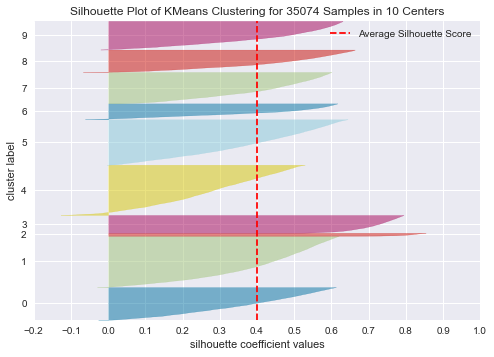

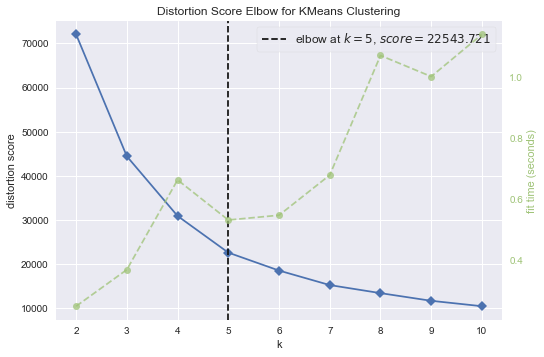

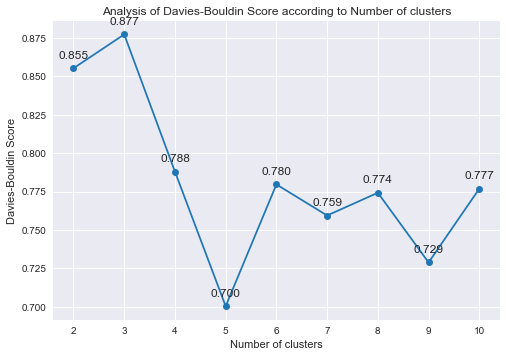

In [7]:
# 3.1 Clustering by using KMeans algorithm
# Preprocessing
reduced_data = preprocessing(subset_df,
                             num_features,
                             None,
                             2)

# The optimal number of clusters search
n_clusters = range(2, 11)
elbow = {}
db_score = []
for n_cluster in n_clusters:      
    # Instantiate the clustering model
    model = KMeans(
        # The number of clusters and the number
        # of centroids to generate
        n_clusters=n_cluster,
        # Method for initialization
        init='k-means++',
        # Maximum number of iterations
        max_iter=300,
        # Verbosity mode
        verbose=0,
        # Determines random number generation
        # for centroid initialization
        random_state=0,
        # KMeans algorithm to use
        algorithm='auto')
    model.fit(reduced_data)
    clusters = model.labels_
    elbow[n_cluster] = model.inertia_
    db_score.append(davies_bouldin_score(reduced_data, clusters))

# Using Sum of Squared Errors
# to find the optimal number of clusters
N_CLUST = find_elbow(list(elbow.keys()),
                     list(elbow.values()),
                     'convex',
                     'decreasing')

# Displaying Distortion Score Elbow
displaying_visualizers(reduced_data, model, True)

# Displaying Davis-Bouldin Score
display_line_plot(n_clusters,
                  db_score,
                  'Number of clusters',
                  'Davies-Bouldin Score',
                  'tab:blue',
                  False)

En utilisant l’algorithme du KMeans avec l’initialisation "k-means++", on obtient :
- Le coefficient de Silhouette moyen de 0,4 ;
- Le nombre optimale de 5 clusters par la méthode du coude ;
- L’index de Davis-Bouldin de 0,7.

For n_clust = 5, the average Silhouette Score is: 0.44.
The Davis-Bouldin Score is: 0.70.


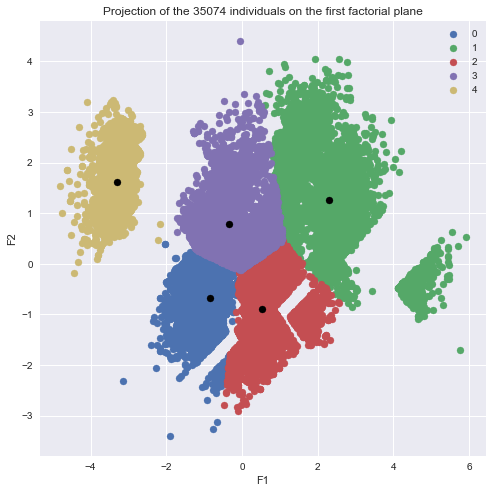

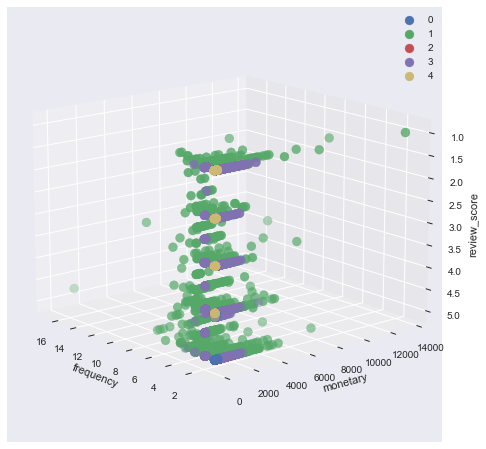

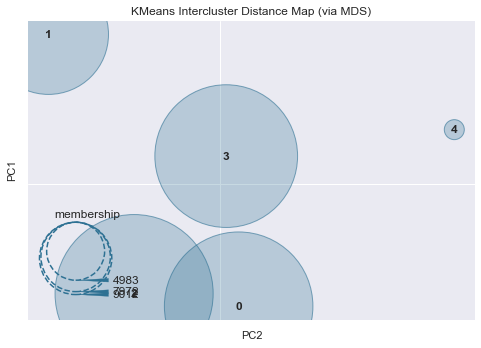

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=5, random_state=0),
                     random_state=0)

In [8]:
# Applying the optimal number of clusters to the model
# Instantiate the clustering model
model = KMeans(
    n_clusters=N_CLUST,
    init='k-means++',
    max_iter=300,
    verbose=0,
    random_state=0,
    algorithm='auto')
model.fit(reduced_data)
kmeans_clusters = model.labels_

# Average Silhouette Score
# The silhouette_score gives the average value for all the samples
# This gives a perspective into the density and separation
# of the formed clusters
avg_silhouette = silhouette_score(reduced_data, kmeans_clusters)
print("For n_clust = {}, the average".format(N_CLUST),
      "Silhouette Score is: {:.2f}.".format(avg_silhouette))

# Davis-Bouldin Score
# The average similarity measure of each cluster
# with its most similar cluster
# Values closer to zero indicate a better clustering
db_score = davies_bouldin_score(reduced_data, kmeans_clusters)
print("The Davis-Bouldin Score "
      "is: {:.2f}.".format(db_score))

# Displaying clusters in 2D and 3D projection
displaying_clusters(subset_df,
                    reduced_data,
                    model,
                    True,
                    'frequency',
                    'monetary',
                    'review_score')

# Displaying Intercluster Distance Maps
intercluster_distance(model, reduced_data, random_state=0)

En appliquant le nombre optimale de 5 clusters au modèle du KMeans, on obtient :
- Le coefficient de Silhouette moyen de 0,44 ;
- L’index de Davis-Bouldin de 0,7.

### 3.2 Clustering en utilisant l'algorithme de clustering hiérarchique

Le clustering hiérarchique permet de partitionner un jeu de données de manière hiérarchique. À chaque étape, il agrège les deux clusters les plus proches. L'algorithme du clustering agglomératif commence par considérer que chaque point est un cluster à lui tout seul. Le modèle trouve ensuite les deux clusters les plus proches et les agglomère en un seul cluster. Les méthodes de lien (linkage methods) permettent de calculer les distances entre deux clusters et de lier les clusters entre eux.

Dimensions of dataset after preprocessing: (35074, 5)
Percentage of variance explained by each component: 
[0.39292098 0.25312439]
[0.39292098 0.64604537]
ward:


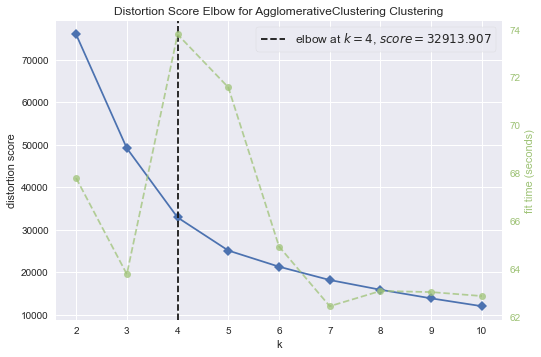

average:


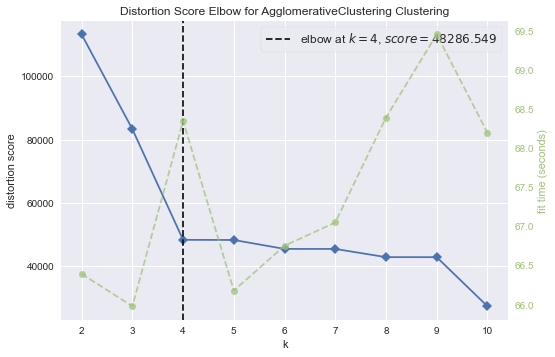

complete:


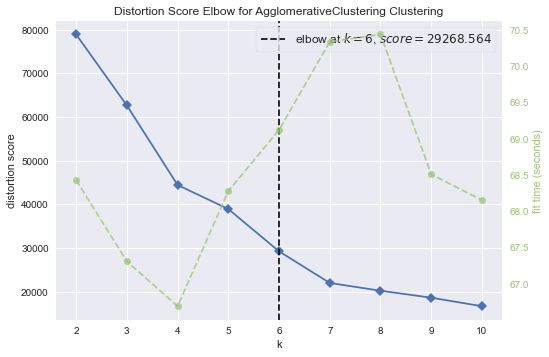

single:


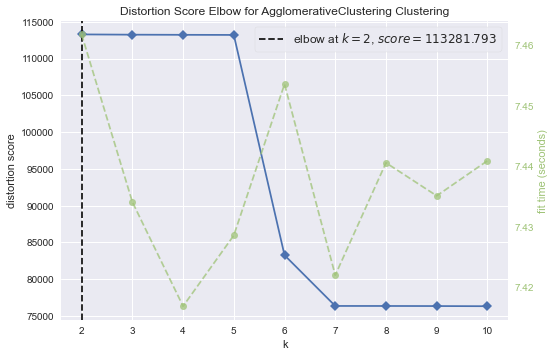

In [9]:
# 3.2 Clustering by using AgglomerativeClustering algorithm
# Preprocessing
reduced_data = preprocessing(subset_df,
                             num_features,
                             None,
                             2)

# Best linkage and the optimal number of clusters search
linkages = ['ward', 'average', 'complete', 'single']
silhouettes = []
db_score = []
for linkage in linkages:  
    # Instantiate the clustering model
    model = AgglomerativeClustering(
        # The number of clusters to find
        n_clusters=2,
        # Metric used to compute the linkage
        affinity='euclidean',
        # Stop early the construction of the tree at n_clusters
        compute_full_tree='auto',
        # The linkage criterion determines which distance to use
        # between sets of observation
        linkage=linkage)
    model.fit(reduced_data)
    clusters = model.labels_
    silhouettes.append(silhouette_score(reduced_data, clusters))
    db_score.append(davies_bouldin_score(reduced_data, clusters))
    
    # Displaying Distortion Score Elbow
    print("{}:".format(linkage))
    displaying_visualizers(reduced_data, model, False)

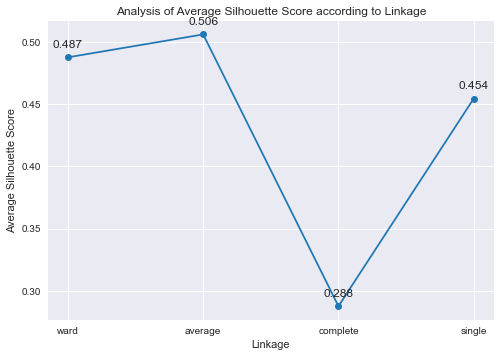

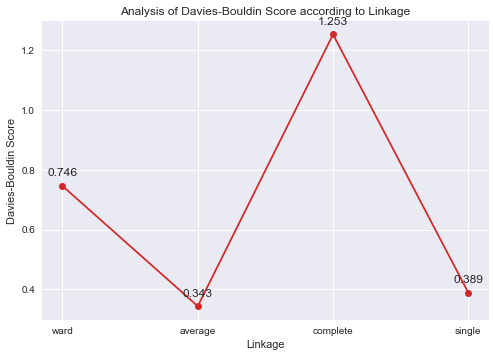

In [10]:
# Displaying Average Silouhette Score
display_line_plot(linkages,
                  silhouettes,
                  'Linkage',
                  'Average Silhouette Score',
                  'tab:blue',
                  False)

# Displaying Davis-Bouldin Score
display_line_plot(linkages,
                  db_score,
                  'Linkage',
                  'Davies-Bouldin Score',
                  'tab:red',
                  False)

En comparant les différentes méthodes de lien (linkage methods) de l’algorithme du clustering agglomératif, on obtient :
- La méthode de lien optimale de "ward" ;
- Le coefficient de Silhouette moyen de 0,49 ;
- Le nombre optimale de 4 clusters par la méthode du coude ;
- L’index de Davis-Bouldin de 0,75.

Avec le clustering de Ward, la distance entre deux clusters est calculée de façon à minimiser la variance inter-cluster.

For n_clust = 4, the average Silhouette Score is: 0.39.
The Davis-Bouldin Score is: 0.82.


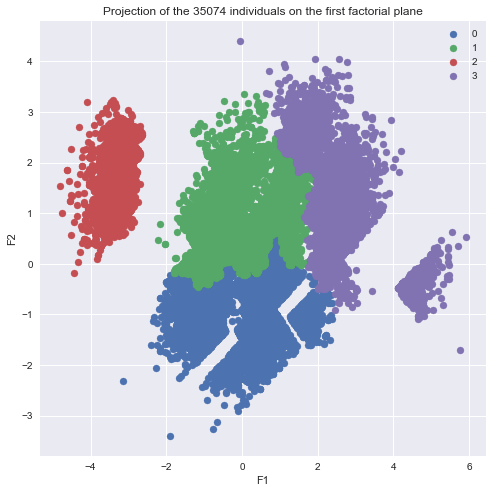

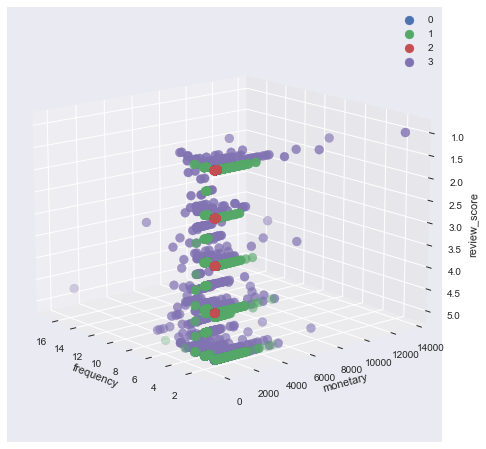

In [11]:
# Applying the optimal number of clusters to the model
# Instantiate the clustering model
N_CLUST = 4
model = AgglomerativeClustering(
    n_clusters=N_CLUST,
    affinity='euclidean',
    compute_full_tree='auto',
    linkage='ward')
model.fit(reduced_data)
agglom_clusters = model.labels_

# Average Silhouette Score
silhouette = silhouette_score(reduced_data, agglom_clusters)
print("For n_clust = {}, the average".format(N_CLUST),
      "Silhouette Score is: {:.2f}.".format(silhouette))

# Davis-Bouldin Score
db_score = davies_bouldin_score(reduced_data, agglom_clusters)
print("The Davis-Bouldin Score "
      "is: {:.2f}.".format(db_score))

# Displaying clusters in 2D and 3D projection
displaying_clusters(subset_df,
                    reduced_data,
                    model,
                    False,
                    'frequency',
                    'monetary',
                    'review_score')

En appliquant le nombre optimale de 4 clusters et la méthode de lien optimale de "ward" au modèle du clustering agglomératif, on obtient :
- Le coefficient de Silhouette moyen de 0,39 ;
- L’index de Davis-Bouldin de 0,82.

### 3.3 Clustering en utilisant l'algorithme du DBSCAN

L'algorithme de DBSCAN itère sur les points du jeu de données. Pour chacun des points, il construit l'ensemble des points atteignables par densité depuis ce point. Si le point considéré n'a pas suffisamment de voisins, il sera alors étiqueté comme du bruit. Cela permet à DBSCAN d'être robuste aux données aberrantes car ce mécanisme les isole.

Dimensions of dataset after preprocessing: (35074, 5)
Percentage of variance explained by each component: 
[0.39292098 0.25312439]
[0.39292098 0.64604537]
optimal epsilon parameter value: 0.38


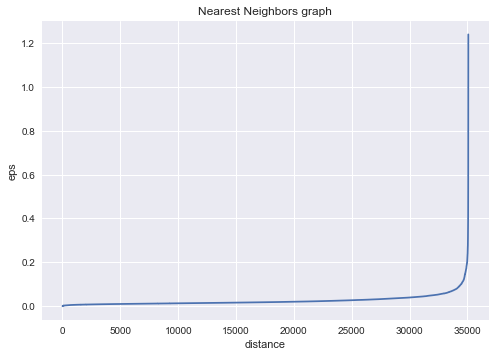

In [12]:
# 3.3 Clustering by using DBSCAN algorithm
# Preprocessing
reduced_data = preprocessing(subset_df,
                             num_features,
                             None,
                             2)

# Using neighborhood graph
# to find the optimal epsilon parameter value
Nneighbors = NearestNeighbors()
knn = Nneighbors.fit(reduced_data)
distances, indices = knn.kneighbors(reduced_data)
distances = np.sort(distances, axis=0)
distances = distances[:, 4]
indices = np.sort(indices, axis=0)
indices = indices[:, 4]

# Using Distances to find the optimal number of parameter eps
EPSILON = find_elbow(list(distances),
                     list(indices),
                     'convex',
                     'increasing')
print("optimal epsilon parameter value: " 
      "{:.2f}".format(EPSILON))

# Displaying Nearest Neighbors graph
plt.plot(indices, distances)
plt.title('Nearest Neighbors graph')
plt.xlabel('distance')
plt.ylabel('eps')
plt.show()

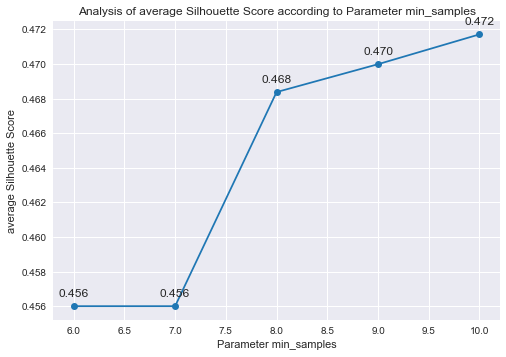

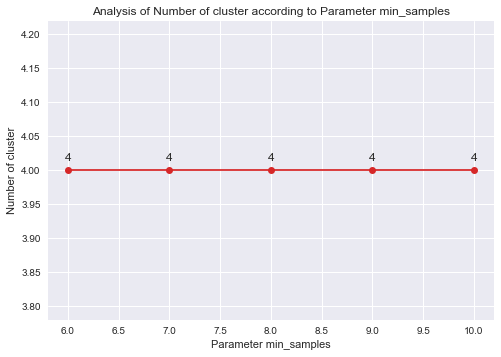

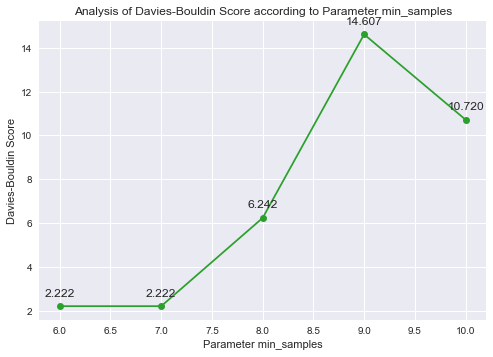

In [13]:
# Best min_samples parameter value search
# min_samples parameter should be at least
# greather than the number of dataset columns
# (min_samples >= columns number + 1)
min_samples_range = range(6, 11)
silhouettes = []
n_clusters = []
db_score = []
for min_sample in min_samples_range: 
    # Instantiate the clustering model
    model = DBSCAN(
        # The maximum distance between two samples for one
        # to be considered as in the neighborhood of the other
        eps=EPSILON,
        # The number of samples (or total weight) 
        # in a neighborhood for a point to be considered as a core point
        min_samples=min_sample,
        # The metric to use when calculating distance
        # between instances in a feature array
        metric='euclidean',
        # The algorithm to be used
        # by the NearestNeighbors module to compute
        # pointwise distances and find nearest neighbors
        algorithm='auto',
        # The power of the Minkowski metric to be used
        # to calculate distance between points
        # If None, p=2 (equivalent to the Euclidean distance)
        p=None,
        # The number of parallel jobs to run: using all processors
        n_jobs=-1)
    model.fit(reduced_data)
    clusters = model.labels_
    silhouettes.append(silhouette_score(reduced_data, clusters))
    n_cluster = np.array(np.unique(clusters))
    n_clusters.append(len(n_cluster))
    db_score.append(davies_bouldin_score(reduced_data, clusters))

# Displaying Average Silouhette Score
display_line_plot(min_samples_range,
                  silhouettes,
                  'Parameter min_samples',
                  'average Silhouette Score',
                  'tab:blue',
                  False)

# Displaying Number of cluster
display_line_plot(min_samples_range,
                  n_clusters,
                  'Parameter min_samples',
                  'Number of cluster',
                  'tab:red',
                  True)

# Displaying Davis-Bouldin Score
display_line_plot(min_samples_range,
                  db_score,
                  'Parameter min_samples',
                  'Davies-Bouldin Score',
                  'tab:green',
                  False)

En utilisant l’algorithme de DBSCAN et le graphique des plus proches voisins, on obtient :
- Le paramètre "epsilon" optimale de 0,38 par la méthode du coude ;
- Le paramètre "min_samples"optimale de 6.

The average Silhouette Score is: 0.46.
The Davis-Bouldin Score is: 2.22.


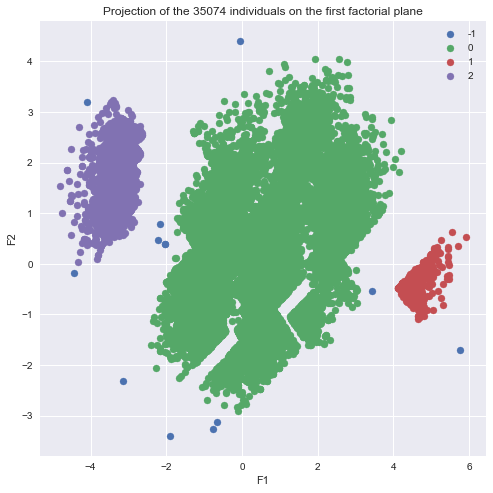

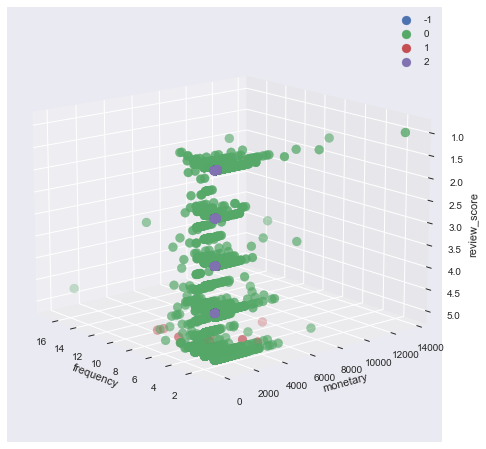

In [14]:
# Applying best parameters to the model
model = DBSCAN(
    eps=EPSILON,  
    min_samples=6,
    metric='euclidean',
    algorithm='auto',
    p=None,
    n_jobs=-1)
model.fit(reduced_data)
dbscan_clusters = model.labels_

# Average Silhouette Score
avg_silhouette = silhouette_score(reduced_data, dbscan_clusters)
print("The average Silhouette Score is: "
      "{:.2f}.".format(avg_silhouette))

# Davis-Bouldin Score
db_score = davies_bouldin_score(reduced_data, dbscan_clusters)
print("The Davis-Bouldin Score "
      "is: {:.2f}.".format(db_score))

# Displaying clusters in 2D and 3D projection
displaying_clusters(subset_df,
                    reduced_data,
                    model,
                    False,
                    'frequency',
                    'monetary',
                    'review_score')

En appliquant les paramètres optimaux au modèle, on obtient :
- Le nombre optimale de 4 clusters ;
- Le coefficient de Silhouette moyen de 0,46 ;
- L’index de Davis-Bouldin de 2,2.

### 3.4 Clustering en utilisant l'algorithme du K-Prototypes

L'algorithme de K-Prototypes est une extension du modèle de KMeans permettant d'utiliser des variables quantitatives et/ou catégorielles.

In [15]:
# 3.4 Clustering by using K-Prototypes algorithm
# Preprocessing
norm_df = preprocessing(subset_df,
                        num_features,
                        cat_features,
                        None)

cat_var = []
features = list(norm_df.columns)
for feature in features:
    if norm_df[feature].dtype == 'object':
        idx = features.index(feature)
        cat_var.append(idx)
print(cat_var)
norm_df.head()

Dimensions of dataset after preprocessing: (35074, 7)
[5, 6]


,recency,frequency,monetary,score,review_score,consumption_habits,shopping_habits
0,-2.259150,3.980132,2.003003,1.118001,-0.596639,sports_leisure,sao paulo
1,-0.211404,3.155618,2.411099,0.421866,-0.834791,bed_bath_table,ibitinga
2,-1.085413,3.125120,1.979293,3.500136,0.835346,bed_bath_table,piracicaba
3,-0.850854,3.125120,2.300327,3.500136,0.835346,furniture_decor,pedreira
4,-0.129834,3.125120,2.132027,1.118001,0.835346,furniture_decor,pedreira


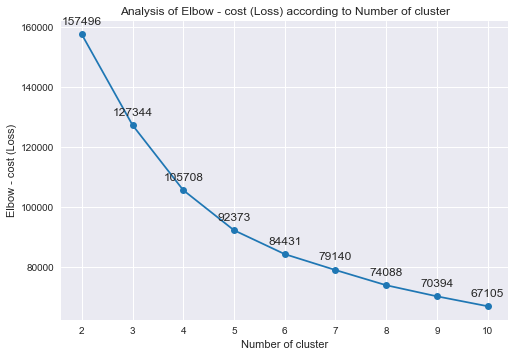

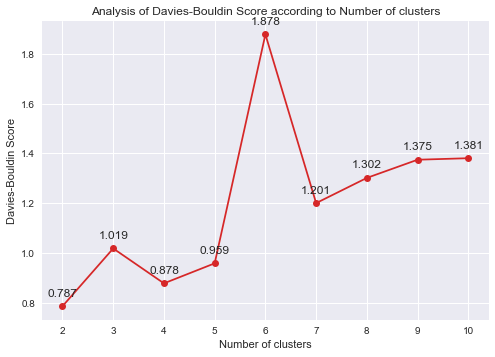

5

In [16]:
# The optimal number of clusters search
n_clusters = range(2, 11)
elbow = {}
cost = []
db_score = []
for n_cluster in n_clusters: 
    # Instantiate the clustering model
    model = KPrototypes(
        # Number of clusters
        n_clusters=n_cluster,
        # Huang random initialization: clustering large datasets
        # with mixed numerical and categorical values
        init='Huang',
        # Random state used to initialize centroids
        random_state=0,
        # Maximum number of iterations
        max_iter=20,
        # The number of parallel jobs to run: using all processors
        n_jobs=-1)
    model.fit(norm_df, categorical=cat_var)
    clusters = model.labels_
    elbow[n_cluster] = model.cost_
    cost.append(model.cost_)
    db_score.append(davies_bouldin_score(reduced_data, clusters))

# Displaying Loss after last training iteration
display_line_plot(n_clusters,
                  cost,
                  'Number of cluster',
                  'Elbow - cost (Loss)',
                  'tab:blue',
                  True)

# Displaying Davis-Bouldin Score
display_line_plot(n_clusters,
                  db_score,
                  'Number of clusters',
                  'Davies-Bouldin Score',
                  'tab:red',
                  False)

# Using Loss after last training iteration
# to find the optimal number of clusters
N_CLUST = find_elbow(list(elbow.keys()),
                     list(elbow.values()),
                     'convex',
                     'decreasing')
N_CLUST

The Davis-Bouldin Score is: 0.96.


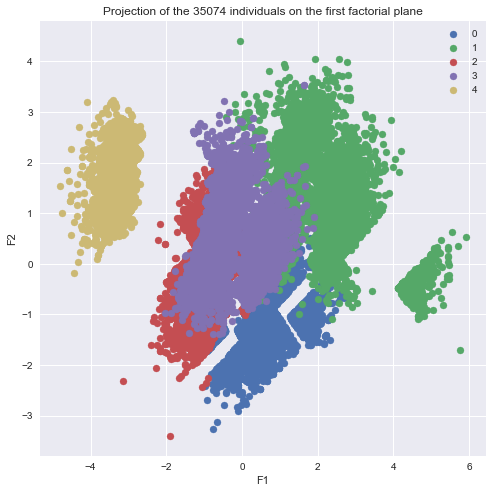

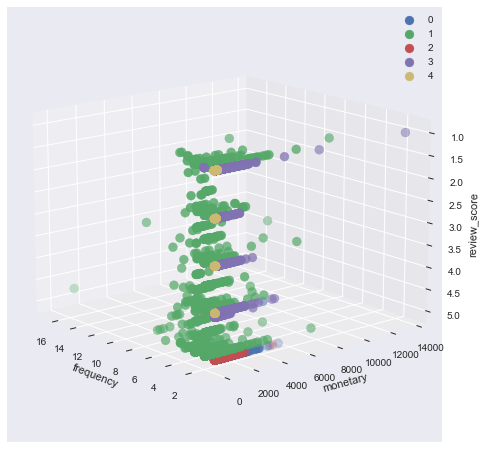

In [17]:
# Applying the optimal number of clusters to the model
# Instantiate the clustering model
model = KPrototypes(
    n_clusters=N_CLUST,
    init='Huang',
    random_state=0,
    max_iter=20,
    n_jobs=-1)
model.fit(norm_df, categorical=cat_var)
kmodes_clusters = model.labels_

# Davis-Bouldin Score
db_score = davies_bouldin_score(reduced_data, kmodes_clusters)
print("The Davis-Bouldin Score "
      "is: {:.2f}.".format(db_score))

# Displaying clusters in 2D and 3D projection
displaying_clusters(subset_df,
                    reduced_data,
                    model,
                    False,
                    'frequency',
                    'monetary',
                    'review_score')

En utilisant l’algorithme du K-Prototypes avec l’initialisation "Huang" et la courbe des pertes, on obtient :
- Le nombre optimale de 5 clusters par la méthode du coude ;
- L’index de Davis-Bouldin de 0,96.

### 3.5 Sélection du modèle final

En essayons les différents algorithmes de clustering, on remarque que :
- L’algorithme du KMeans est rapide et permet de segmenter l’ensemble des clients mais le modèle ne fonctionne qu’avec des variables numériques.
- L’algorithme du Clustering agglomératif est moins rapide et ne permet pas de segmenter l’ensemble des clients à cause des problèmes de mémoire.
- L’algorithme de DBSCAN permet de segmenter l’ensemble des clients mais le modèle considère certains clients comme étant des valeurs aberrantes et ne fonctionne qu’avec des variables numériques.
- L’algorithme de K-Prototypes permet de segmenter l’ensemble des clients et d’utiliser les variables catégorielles mais le modèle est moins rapide.

L’algorithme du KMeans est le modèle final sélectionné pour effectuer la segmentation des clients.

## 4. Segmentation de l'ensemble des clients en matière de commandes et de satisfaction

Nous allons commencer par appliquer l'algorithme du KMeans à l'ensemble des 96096 clients.

### 4.1 Application de l'algorithme du KMeans

Dimensions of dataset after preprocessing: (96096, 5)
Percentage of variance explained by each component: 
[0.3699825  0.24512033]
[0.3699825  0.61510283]


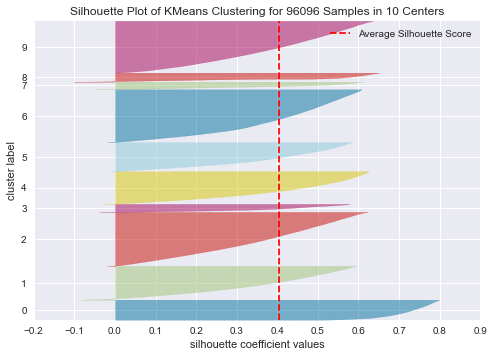

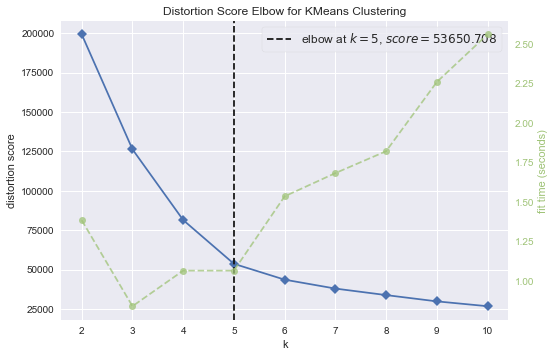

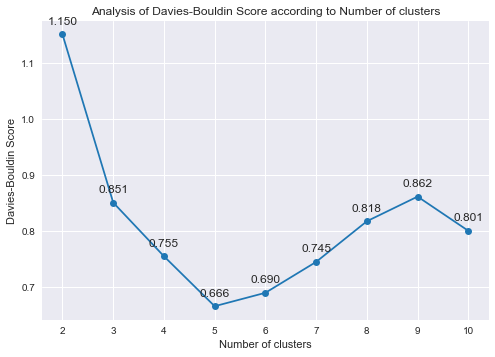

In [18]:
# 4. Segmentation of all customers in terms of orders and satisfaction
# 4.1 Applying KMeans algorithm
# Preprocessing
reduced_data = preprocessing(customers_df,
                             num_features,
                             None,
                             2)

# The optimal number of clusters search
n_clusters = range(2, 11)
elbow = {}
db_score = []
for n_cluster in n_clusters: 
    # Instantiate the clustering model
    model = KMeans(
        n_clusters=n_cluster,
        init='k-means++',
        max_iter=300,
        verbose=0,
        random_state=0,
        algorithm='auto')
    model.fit(reduced_data)
    clusters = model.labels_
    elbow[n_cluster] = model.inertia_
    db_score.append(davies_bouldin_score(reduced_data, clusters))

# Using Sum of Squared Errors
# to find the optimal number of clusters
N_CLUST = find_elbow(list(elbow.keys()),
                     list(elbow.values()),
                     'convex',
                     'decreasing')

# Displaying Distortion Score Elbow
displaying_visualizers(reduced_data, model, True)

# Displaying Davis-Bouldin Score
display_line_plot(n_clusters,
                  db_score,
                  'Number of clusters',
                  'Davies-Bouldin Score',
                  'tab:blue',
                  False)

En utilisant l’algorithme du KMeans, on obtient :
- Le nombre optimale de 5 clusters par la méthode du coude ;
- Le coefficient de Silhouette moyen de 0,4 ;
- L’index de Davis-Bouldin de 0,67.

For n_clust = 5, the average Silhouette Score is: 0.45.
The Davis-Bouldin Score is: 0.67.


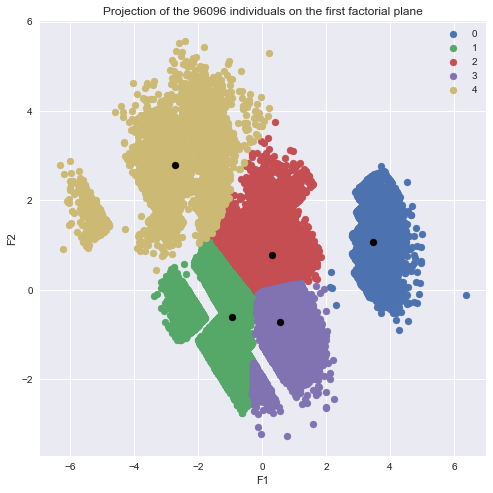

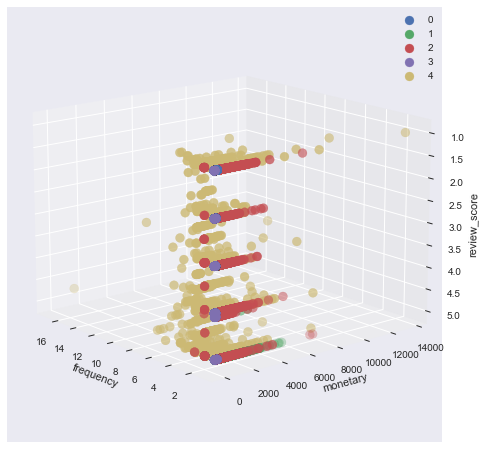

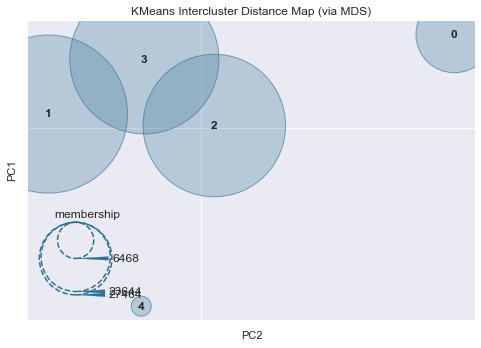

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=5, random_state=0),
                     random_state=0)

In [19]:
# Applying the optimal number of clusters to the model
# Instantiate the clustering model
model = KMeans(
    n_clusters=N_CLUST,
    init='k-means++',
    max_iter=300,
    verbose=0,
    random_state=0,
    algorithm='auto')
model.fit(reduced_data)
clusters = model.labels_

# Average Silhouette Score
avg_silhouette = silhouette_score(reduced_data, clusters)
print("For n_clust = {}, the average".format(N_CLUST),
      "Silhouette Score is: {:.2f}.".format(avg_silhouette))

# Davis-Bouldin Score
db_score = davies_bouldin_score(reduced_data, clusters)
print("The Davis-Bouldin Score "
      "is: {:.2f}.".format(db_score))

# Displaying clusters in 2D and 3D projection
displaying_clusters(customers_df,
                    reduced_data,
                    model,
                    True,
                    'frequency',
                    'monetary',
                    'review_score')

# Displaying Intercluster Distance Maps
intercluster_distance(model, reduced_data, random_state=0)

En appliquant le nombre optimale de 5 clusters au modèle du KMeans, on obtient :
- Le coefficient de Silhouette moyen de 0,45 ;
- L’index de Davis-Bouldin de 0,67.

### 4.2 Définition des différents segments

En utilisant le score moyen qui permet de segmenter les clients en matière de commandes et de satisfaction, on obtient les différents segments suivants :
- Platinum : clients fréquents, satisfaits et dépensiers (bons clients);
- Gold : clients non fréquents, très satisfaits avec un budget moyen ;
- Silver : clients non fréquents, moins satisfaits avec un budget moyen ;
- Bronze : clients non fréquents, très satisfaits avec un petit budget ;
- Unrelevant : clients non fréquents, moins satisfaits et moins dépensiers (moins bons clients).

In [20]:
# 4.2 Definition of the different segments
def segmentation(data, clusters):
    """This function defines custormers segments
    - 'Platinum': frequent, satisfied cutomers and heavy spenders ;
    - 'Gold': not frequent, very satisfied customers and average spenders ;
    - 'Silver': not frequent, less satisfied customers and average spenders ;
    - 'Bronze': not frequent, very satisfied customers and lower spenders ;
    - 'Unrelevant': not frequent, not satisfied and lower spenders.
    """
    data = data.assign(cluster=clusters)
    clusters_df = data.groupby('cluster').agg(
        recency=('recency', 'mean'),
        frequency=('frequency', 'mean'),
        monetary=('monetary', 'mean'),
        r_score=('r_score', 'mean'),
        f_score=('f_score', 'mean'),
        m_score=('m_score', 'mean'),
        rfm_score=('rfm_score', 'mean'),
        review_score=('review_score', 'mean'),
        score=('score', 'mean'),
        cluster_size=('customer_unique_id', 'count')
    ).round(1).sort_values(by='score', ascending=False)
    clusters_df['cluster'] = clusters_df.index
    clusters_df.reset_index(inplace=True, drop=True)
    segments = {}

    # Segments definition according to the average score
    for i in range(len(clusters_df)):
        score = clusters_df.loc[i, 'score']
        cluster = clusters_df.loc[i, 'cluster']
        
        if score > 3.5:
            clusters_df.loc[i, 'segment'] = 'platinum'
        elif score <= 3.5 and score > 2.5:
            clusters_df.loc[i, 'segment'] = 'gold'
        elif score <= 2.5 and score > 2:
            clusters_df.loc[i, 'segment'] = 'silver'
        elif score <= 2 and score > 1:
            clusters_df.loc[i, 'segment'] = 'bronze'
        else:
            clusters_df.loc[i, 'segment'] = 'unrelevant'
            
    clusters = list(clusters_df.cluster)
    ranks = list(clusters_df.segment)
    for cluster, rank in zip(clusters, ranks):
        segments[cluster] = rank
    clusters_df = clusters_df.set_index('cluster')
    data['segment'] = data['cluster'].map(segments)
    return data, clusters_df

In [21]:
segments_df, clusters_df = segmentation(customers_df, clusters)
print(clusters_df.shape)
clusters_df

(5, 11)


,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,review_score,score,cluster_size,segment
cluster,,,,,,,,,,,
4,270.2,2.2,456.5,3.2,5.0,4.5,369.5,3.7,3.7,5060,platinum
1,191.3,1.0,202.4,3.9,1.0,3.6,406.4,4.9,3.1,33460,gold
2,333.9,1.0,223.5,2.6,1.0,3.7,273.6,3.0,2.2,23644,silver
3,337.4,1.0,60.8,2.5,1.0,1.7,261.2,4.7,2.0,27464,bronze
0,425.8,1.0,63.5,1.7,1.0,1.7,186.0,1.8,1.0,6468,unrelevant


In [22]:
print(segments_df.shape)
segments_df

(96096, 23)


,customer_unique_id,frequency,price,payment_value,freight_value,review_score,recency,day,month,year,...,monetary,r_score,f_score,m_score,rfm_score,score,shopping_habits,consumption_habits,cluster,segment
0,8d50f5eadf50201ccdcedfb9e2ac8455,17,729.62,927.63,172.42,4.764706,58,20,8,2018,...,927.63,5,5,5,555,4,sao paulo,sports_leisure,4,platinum
1,3e43e6105506432c953e165fb2acf44c,10,897.15,1536.84,138.78,2.800000,232,27,2,2018,...,1536.84,3,5,5,355,3,ibitinga,bed_bath_table,4,platinum
2,6469f99c1f9dfae7733b25662e7f1782,8,639.30,905.11,85.54,5.000000,111,28,6,2018,...,905.11,5,5,5,555,5,piracicaba,bed_bath_table,4,platinum
3,ca77025e7201e3b30c44b472ff346268,8,723.65,1336.40,186.09,5.000000,138,1,6,2018,...,1336.40,5,5,5,555,5,pedreira,furniture_decor,4,platinum
4,1b6c7548a2a1f9037c1fd3ddfed95f33,8,691.21,1085.99,134.22,5.000000,245,14,2,2018,...,1085.99,3,5,5,355,4,pedreira,furniture_decor,4,platinum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96091,f30aca5c2b78d7b1e98ab7e62ef2fe08,1,12.70,30.62,17.92,5.000000,475,29,6,2017,...,30.62,1,1,1,111,2,caxias do sul,unknown,3,bronze
96092,f30af10a5ba601481751893e7be59833,1,98.00,66.85,21.18,3.000000,476,28,6,2017,...,66.85,1,1,2,112,1,santos,unknown,0,unrelevant
96093,f30ba18c5ecb2b814dcbf77fedcbe195,1,112.90,112.90,0.00,5.000000,183,17,4,2018,...,112.90,4,1,3,413,3,guariba,watches_gifts,1,gold
96094,f30d87665f2b59543a06092e03430a0f,1,17.10,29.89,12.79,5.000000,188,12,4,2018,...,29.89,4,1,1,411,2,garulhos,signaling_and_security,3,bronze


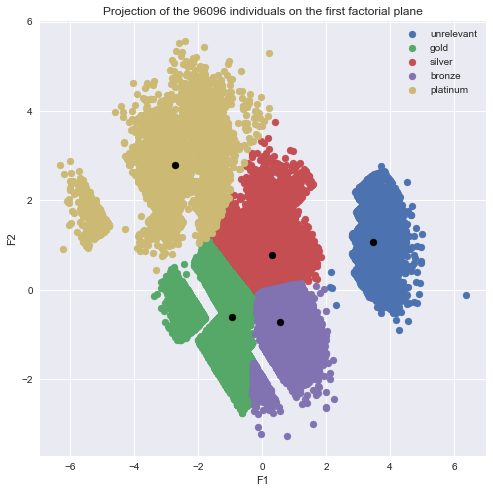

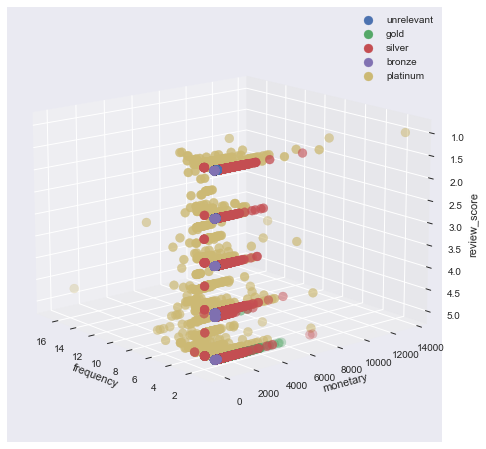

In [23]:
# Displaying customers segments
# 2D plot
# Setup the figure
fig = plt.figure(figsize=(8, 8))
for cluster in np.unique(clusters):
    label_df = segments_df.segment[segments_df.cluster == cluster]
    segment = np.unique(label_df)[0]
    plt.scatter(
        reduced_data[clusters == cluster, 0],
        reduced_data[clusters == cluster, 1],
        label=segment,
        alpha=1,
        cmap='viridis')

# Retrieve the clusters centers
centroids = model.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    color='black',
    alpha=1)
plt.legend()
plt.title("Projection of the {} individuals "
    "on the first factorial plane".format(reduced_data.shape[0]))
plt.xlabel('F1')
plt.ylabel('F2')
plt.show()


# 3D plot
# Setup the figure
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(projection='3d')
clusters = list(np.unique(segments_df.cluster))
for i in clusters:
    label_df = segments_df.segment[segments_df.cluster == i]
    segment = np.unique(label_df)[0]
    ax.scatter(
        segments_df.frequency[segments_df.cluster == i],
        segments_df.monetary[segments_df.cluster == i],
        segments_df.review_score[segments_df.cluster == i],
        s=80,
        label=segment)
ax.view_init(195, 40)
ax.set_xlabel('frequency')
ax.set_ylabel('monetary')
ax.set_zlabel('review_score')
ax.legend()
plt.show()

## Conclusion

Le clustering a permis d’obtenir 5 segments de l’ensemble des clients avec les classements des bons et moins bons clients en matière de commandes et de satisfaction.